<a href="https://colab.research.google.com/github/SimonR99/QSVM-genetics/blob/main/qsvm-genetics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit==0.37.0
!pip install pylatexenc==2.10
!pip install qiskit_machine_learning==0.4.0
!pip install pymoo==0.5.0

# Support Vector Machines using Quantum Kernel

SVMs, or "Support-vector machines", are used for many artificial intelligence tasks because they don't require a lot of computational power to achieve acceptable results. To classify data, the algorithm uses kernels to indicate how data should be distributed in a space. Among other things, it's possible to choose a linear kernel. This simply draws a line and separates the data into two groups. It's also possible to use more complex kernels, such as polynomial kernels. These are generally more efficient but take longer to compute. SVMs are interesting in the era of quantum computing since, for certain types of data, a quantum kernel can provide a significant speed-up. Of course, the speed-up only occurs for certain types of data that require complex kernels. (A linear kernel will remain faster). In some cases, it's even possible to achieve better prediction accuracy since one can convert into a space that is not classically accessible.

# Classification of the "Iris datasets" data

To provide us with a comparison point that's simpler than a dataset from language processing, this will prevent the main issue from being dimensionality reduction.

## Importing the libraries

In [2]:
# General Imports
import numpy as np
import pandas as pd
import math as math

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets, model_selection, naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate, IGate
from qiskit_machine_learning.kernels import QuantumKernel


# NLP Imports
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Produce the same result every time:
np.random.seed(500)

## Division des données

Pour réduire le temps de calcul, seulement 2 attributs (dimension) sont utilisés pour faire les comparaisons. Les données sont séparées en deux groupes pour pouvoir faire des tests avec des données jamais vues par l'algorithme auparavant.

In [4]:
# Number of dimensions used
n_dim = 2

# The ratio must be equal to 1.
train_size=0.5
gene_size = 0.25
test_size = 0.25

iris = datasets.load_iris()
X = iris.data[:, :n_dim]
y = iris.target
# Do not train the genetic model with all the test data; keep some to validate later that the found feature map works for unseen data.
sample_train, sample_temp, label_train, label_temp = model_selection.train_test_split(X, y, train_size=train_size, test_size=1-train_size, random_state=110)
sample_gene, sample_test, label_gene, label_test = model_selection.train_test_split(sample_temp, label_temp, train_size=gene_size/(gene_size+test_size), test_size=test_size/(gene_size+test_size), random_state=110)

## Traitement des données

In [5]:
# Normalisations
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_gene = std_scale.transform(sample_gene)
sample_test = std_scale.transform(sample_test)

# Size adjustement
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_gene = minmax_scale.transform(sample_gene)
sample_test = minmax_scale.transform(sample_test)

## Creation of the Quantum "Feature Map"

The quantum "feature map" is an oracle that serves as a kernel (using a callback method) and will eventually be passed as a parameter to the classic SVM. The choice of this type of quantum "feature map" comes from the fact that it is more challenging to obtain classically. Thus, if we want to reproduce this type of kernel classically, the quantum version would be faster.

The following function allows converting a bit string into quantum gates. Each sequence of five bits corresponds to a gate. This function will be passed as a parameter to the genetic algorithm to build the circuits.

The first three bits indicate if the gate is fixed (Hadamar, Pauli, CNOT, ...) or if it is parameterized according to the inputs (Ry, Rx, ...). When the gate is parameterized, the last two bits of the five-bit sequence are used as the proportionality constant of the angle encoding equation.

### Here is the conversion table of the gates used:


| Code | Gate | Note                                                                 |
|------|------|----------------------------------------------------------------------|
| 000  | H    | Hadamar                                                              |
| 001  | CNOT | The control bit is the current qubit, and the controlled qubit is the next one. |
| 010  | I    | No gate (identity)                                                   |
| 011  | Rx   | Rotation on the x-axis                                               |
| 100  | Rz   | Rotation on the z-axis                                               |
| 101  | I    | No gate (identity)                                                   |
| 110  | I    | No gate (identity)                                                   |
| 111  | Ry   | Rotation on the y-axis                                               |




### Here is the conversion table of the angles used:

| Code | Rotation |
|------|----------|
| 00   | pi       |
| 01   | pi/2     |
| 10   | pi/4     |
| 11   | pi/8     |


In [6]:
def create_circuit_from_bit_string(quantum_circuit, values, bitstring, num_dimensions):
    num_qubits = quantum_circuit.num_qubits
    gate_lenght = 5
    string_gates = [bitstring[i:i+gate_lenght] for i in range(0, len(bitstring), gate_lenght)]
    has_cnot = False
    angle_index = 0
    for gate_number in range(0, len(string_gates)):
        index_qubit = gate_number % num_qubits
        index_parameter = gate_number % num_dimensions
        gate_string = string_gates[gate_number]
        gate_type = gate_string[0:3]
        angle_type = gate_string[4:]

        if angle_type == '00':
            angle = math.pi
        elif angle_type == '01':
            angle = math.pi / 2
        elif angle_type == '10':
            angle = math.pi / 4
        else:
            angle = math.pi / 8

        angle *= values[angle_index]

        if gate_type == '000':
            quantum_circuit.h(index_qubit)
        elif gate_type == '001' and index_qubit < num_qubits - 1:
            has_cnot = True
            quantum_circuit.cnot(index_qubit, index_qubit+1)
        elif gate_type == '011':
            quantum_circuit.rx(angle, index_qubit)
            angle_index = (angle_index+1)%num_dimensions
        elif gate_type == '100':
            quantum_circuit.rz(angle, index_qubit)
            angle_index = (angle_index+1)%num_dimensions
        elif gate_type == '111':
            quantum_circuit.ry(angle, index_qubit)
            angle_index = (angle_index+1)%num_dimensions


    return [quantum_circuit.num_parameters == num_dimensions, has_cnot == False]

In [7]:
def calculate_sm(bitstring):
    gate_lenght = 5
    total_cnot = 0
    total_local = 0
    string_gates = [bitstring[i:i+gate_lenght] for i in range(0, len(bitstring), gate_lenght)]
    for gate in string_gates:
        if gate[0:3] in ["000", "100", "011", "111"]:
            total_local+=1
        if gate[0:3] in ["001"]:
            total_cnot+=1

    sm = (total_local+2*total_cnot)/(total_cnot+total_local)

    return sm



## QSVM using ZZfeature map


In [8]:
n_dim=2
zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=3, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.6052631578947368


## Base circuit (example)

The following circuit represents an example of a circuit created from the bit string. The results of this circuit are modest since it hasn't been optimized.

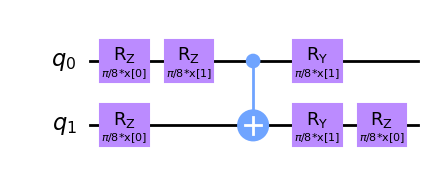

In [9]:
values = ParameterVector('x', length=2)

qc = QuantumCircuit(2)

bitstring = '1101110110110001010010000101010100000111101111011010001010101011110000001001111110100100101110101010'

[success, has_cnot] = create_circuit_from_bit_string(qc, values, bitstring, 2)
if success == False:
    print('Not all parameters are used, so this feature map is unusable')

qc.draw(output='mpl')

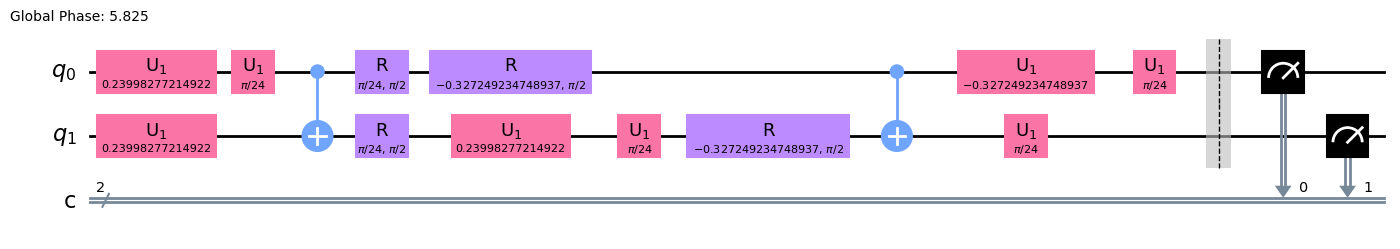

In [10]:
gene_kernel = QuantumKernel(feature_map=qc, quantum_instance=Aer.get_backend('statevector_simulator'))
gene_circuit = gene_kernel.construct_circuit(sample_train[0], sample_train[1])
gene_circuit.decompose().decompose().draw(output='mpl')

In [11]:
svc = SVC(kernel=gene_kernel.evaluate)
svc.fit(sample_train, label_train)
qsvm_score = svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {qsvm_score}')

Callable kernel classification test score: 0.2894736842105263


## Genetic Algorithm and Optimization

Cette section définit un problème d'optimisation à l'aide de la librairie Pymoo. Cette librairie nous permet de gérer automatiquement l'évolution du bit string correspondant au circuit quantique.

On définit les paramètres d'optimisation du problème : f1 représente la précision et f2 représente la profondeur du circuit. En fait, f1 représente 1 moins la précision, car nous ne pouvons effectuer qu'une minimisation. Nous pouvons ainsi effectuer une minimisation sur f1 et f2 afin de trouver le circuit ayant la meilleure combinaison de profondeur et de précision.

In [12]:
import numpy as np
from pymoo.util.misc import stack
from pymoo.core.problem import ElementwiseProblem



class ProblemIris(ElementwiseProblem):

    def __init__(self, n_dim, n_qubit):
        super().__init__(n_var=100,
                         n_obj=2,
                         n_constr=1,
                         xl=np.zeros(100),
                         xu=np.ones(100))

        self.n_dim = n_dim
        self.n_qubit =n_qubit

    def _evaluate(self, x, out, *args, **kwargs):
        def toStr(a):
            return str(int(a == True))
        bitstring = ''.join(map(toStr,x))

        values = ParameterVector('x', length=self.n_dim)

        qc = QuantumCircuit(self.n_qubit)

        success = create_circuit_from_bit_string(qc, values, bitstring, self.n_dim)
        if success[0]:
            gene_kernel = QuantumKernel(feature_map=qc, quantum_instance=Aer.get_backend('statevector_simulator'))
            svc = SVC(kernel=gene_kernel.evaluate)
            svc.fit(sample_train, label_train)
            score = svc.score(sample_gene, label_gene)

            f1 = 1 - score
        else:
            f1 = 1

        #print('%s : %f' % (bitstring, 1 - f1))

        #sm = calculate_sm(bitstring)
        f2 = qc.depth()

        out["F"] = anp.column_stack([f1, f2])
        out["G"] = anp.column_stack([f1 - 0.5])

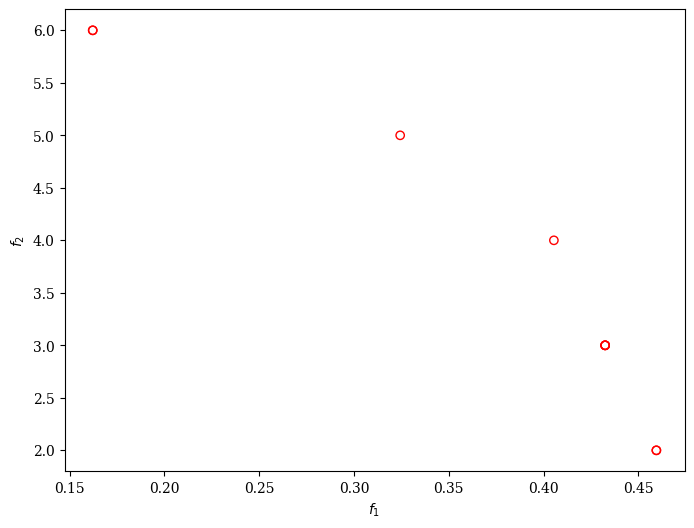

In [13]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.core.evaluator import set_cv
from pymoo.util.termination.no_termination import NoTermination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import autograd.numpy as anp



# Creation of the problem object
problem = ProblemIris(n_dim,2)

# Creation of the genetic algorithm
algorithm = NSGA2(pop_size=10,
                  sampling=get_sampling("bin_random"),
                  crossover=get_crossover("bin_two_point"),
                  mutation=get_mutation("bin_bitflip"),
                  eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()


We can see here that some of the results are better in terms of depth, but not as good in terms of accuracy, while other results show the opposite. However, our best results are around 80% accuracy with a depth of about 3. This graph thus demonstrates the need to balance the required accuracy with depth depending on the use case.

#### Conversion of the best result into a bitstring

In [14]:
def toStr(a):
    return str(int(a == True))
index_best_solution = np.argmin(res.F[:,0])
bestBitString = ''.join(map(toStr,res.X[index_best_solution]))
print("Best solution : %s" % bestBitString)

Best solution : 1101110000110010000111110100110001010111101111010110001010101011110000000101111110100100101110101010


### Testing with data the algorithm has never seen

We split the test data into two parts to ensure that the data in this test was not used during the optimization of the algorithm. By doing so, we demonstrated that the genetic algorithm produces quality results even when the data has never been seen before, which is necessary for real-world use cases.

In [15]:
values = ParameterVector('x', length=2)

qc = QuantumCircuit(2)

(success, has_cnot) = create_circuit_from_bit_string(qc, values, bestBitString, 2)
if success == False:
    print('Not all parameters are used, so this feature map is unusable')

gene_kernel = QuantumKernel(feature_map=qc, quantum_instance=Aer.get_backend('statevector_simulator'))
gene_circuit = gene_kernel.construct_circuit(sample_train[0], sample_train[1])
gene_circuit.decompose().decompose().draw(output='mpl')
svc = SVC(kernel=gene_kernel.evaluate)
svc.fit(sample_train, label_train)
genetic_score = svc.score(sample_test, label_test)

print(f'Result with new data : {genetic_score}')

Result with new data : 0.7631578947368421


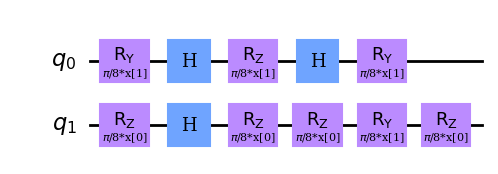

6


In [16]:
values = ParameterVector('x', length=2)

qc = QuantumCircuit(2)

bitstring = bestBitString

[success, has_cnot] = create_circuit_from_bit_string(qc, values, bitstring, 2)
if success == False:
    print('Not all parameters are used, so this feature map is unusable')

display(qc.draw(output='mpl'))
print(qc.depth())

## Comparison with the classical versions

In [17]:
rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(sample_train, label_train)
poly = SVC(kernel='poly', degree=3, C=1).fit(sample_train, label_train)
qsv = SVC(kernel='poly', degree=3, C=1).fit(sample_train, label_train)

In [18]:
poly_pred = poly.predict(sample_test)
rbf_pred = rbf.predict(sample_test)

In [19]:
poly_accuracy = accuracy_score(label_test, poly_pred)
poly_f1 = f1_score(label_test, poly_pred, average='weighted')
rbf_accuracy = accuracy_score(label_test, rbf_pred)
rbf_f1 = f1_score(label_test, rbf_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))
print('QSVM with ZZ : ', "%.2f" % (zzcb_score*100))
print('QSVM with non-optimized genetic algo : ', "%.2f" % (qsvm_score*100))
print('QSVM with optimized genetic algo : ', "%.2f" % (genetic_score*100))


Accuracy (Polynomial Kernel):  73.68
F1 (Polynomial Kernel):  71.93
Accuracy (RBF Kernel):  63.16
F1 (RBF Kernel):  51.14
QSVM with ZZ :  60.53
QSVM with non-optimized genetic algo :  28.95
QSVM with optimized genetic algo :  76.32


When comparing with classical algorithms, we see that the genetic algorithm manages to produce better results, which is very promising. Moreover, the optimization part greatly improves accuracy.

## Data Compression

With the genetic algorithm, it's also possible to reduce the number of qubits needed for dimension encoding. The following cells are dedicated to this optimization.


In [20]:
# Number of dimensions used
n_dim = 4

# The ratio must be equal to 1.
train_size=0.5
gene_size = 0.25
test_size = 0.25

iris = datasets.load_iris()
X = iris.data[:, :n_dim]
y = iris.target
# Do not train the genetic model with all the test data; keep some to validate later that the found feature map works for unseen data.
sample_train, sample_temp, label_train, label_temp = model_selection.train_test_split(X, y, train_size=train_size, test_size=1-train_size, random_state=110)
sample_gene, sample_test, label_gene, label_test = model_selection.train_test_split(sample_temp, label_temp, train_size=gene_size/(gene_size+test_size), test_size=test_size/(gene_size+test_size), random_state=110)

# Normalisations
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_gene = std_scale.transform(sample_gene)
sample_test = std_scale.transform(sample_test)

# Size adjustment
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_gene = minmax_scale.transform(sample_gene)
sample_test = minmax_scale.transform(sample_test)

# Creation of the problem object
problem = ProblemIris(n_dim,2)

# Creation of the genetic algorithm according to our problem.
algorithm = NSGA2(pop_size=10,
                sampling=get_sampling("bin_random"),
                crossover=get_crossover("bin_two_point"),
                mutation=get_mutation("bin_bitflip"),
                eliminate_duplicates=True)

res = minimize(problem,
            algorithm,
            ('n_gen', 10),
            seed=1,
            verbose=False)

def toStr(a):
    return str(int(a == True))
index_best_solution = np.argmin(res.F[:,0])
bestBitString = ''.join(map(toStr,res.X[index_best_solution]))
print("Best solution : %s" % bestBitString)

values = ParameterVector('x', length=n_dim)

qc = QuantumCircuit(2)

(success, has_cnot) = create_circuit_from_bit_string(qc, values, bestBitString, n_dim)
if success == False:
    print('Not all parameters are used, so this feature map is unusable')

gene_kernel = QuantumKernel(feature_map=qc, quantum_instance=Aer.get_backend('statevector_simulator'))
gene_circuit = gene_kernel.construct_circuit(sample_train[0], sample_train[1])
gene_circuit.decompose().decompose().draw(output='mpl')
svc = SVC(kernel=gene_kernel.evaluate)
svc.fit(sample_train, label_train)
genetic_score = svc.score(sample_test, label_test)

print(f'Result with new data : {genetic_score}')


Best solution : 0000110000101110100111101000001001101010100100110010111101100000111111110100111000011000000001111101
Result with new data : 0.9473684210526315


As we can see, it's possible to achieve better accuracy when we encode more dimensions. Unlike the classical "feature map", we didn't need more qubits to increase the number of dimensions. The circuit converges quickly, and the maximum depth of the circuit is 10 at most with 2 qubits.

# Conclusion

In conclusion, the automatic design of a "feature map" by a genetic algorithm is promising in the sense that it allows finding a suitable "feature map" for the problem. However, since this algorithm takes a lot of time during the training phase, it seems unlikely that it will be used in the future. It would be possible to use better optimization algorithms to perform this task. All in all, this is our version of the QSVM that performed the best.

# Bibliography

Quantum support vector machine for big data classification, Patrick Rebentrost

https://arxiv.org/abs/1307.0471


Breast Cancer Detection with QSVM.

https://github.com/PatrickHuembeli/QSVM-Introduction/blob/master/Quantum%20Support%20Vector%20Machines.ipynb


Multi class SVM (SKlearn)

https://www.baeldung.com/cs/svm-multiclass-classification#:~:text=Multiclass%20Classification%20Using%20SVM&text=It%20supports%20binary%20classification%20and,into%20multiple%20binary%20classification%20problems.


Lab 3 (Qiskit Summer School 2021)

https://github.com/jatin-47/QGSS-2021/blob/main/Lab%203/lab-3.ipynb


Automatic design of quantum feature maps

https://arxiv.org/abs/2105.12626


Author : Simon Roy, Simon Gaudette, Arnaud Brouillet-gagnon